### Simple topic modelings - with google news 

In [1]:
import pandas as pd 
import os 
#from utils import Args
import json 
import numpy as np
from sentence_transformers import SentenceTransformer
from topic_model_utils import *
#model_setup,train_topic_model,eval_topic_model,train_and_eval,hyper_param_permutation,Args,pack_update_param

In [2]:
## define some global paths and variables  
LOAD_EMB = False
TUNE = True
res_folder = '/data/chuang/news_scrape/data/news_search_res'
news_output_p = os.path.join(res_folder,'search_results_raw.csv')
emb_path  = os.path.join(res_folder,'sentence_embeddings.npy')
docs_path = os.path.join(res_folder,'docs.npy')
topic_model_out_path = os.path.join(res_folder,'topic_model')

## Evaluate raw data 

In [3]:
## raw data exploration 
df = pd.read_csv(news_output_p)
df.head()


,newspaper_name,time_start,time_end,year,month,day,title,link,body_length,text,education,Keep_tag
0,iwnsvg.com,2010-01-01,2010-02-01,2010,1,5,70 patients relocated after fire in St. Vincen...,https://news.google.com/rss/articles/CBMiUWh0d...,404,70 patients relocated after fire in St. Vincen...,1,1
1,iwnsvg.com,2010-01-01,2010-02-01,2010,1,14,SVG 'paid too little attention' to disabled – ...,https://news.google.com/rss/articles/CBMiTGh0d...,444,SVG 'paid too little attention' to disabled – ...,1,1
2,iwnsvg.com,2010-01-01,2010-02-01,2010,1,19,St. Vincent PM unveils EC$913M budget – iWitne...,https://news.google.com/rss/articles/CBMiRmh0d...,978,St. Vincent PM unveils EC$913M budget – iWitne...,1,1
3,iwnsvg.com,2010-01-01,2010-02-01,2010,1,25,Political parties urged to control supporters ...,https://news.google.com/rss/articles/CBMiRWh0d...,696,Political parties urged to control supporters ...,0,0
4,iwnsvg.com,2010-01-01,2010-02-01,2010,1,26,"No tax, no borrowing, less VAT in 2010 budget ...",https://news.google.com/rss/articles/CBMiTmh0d...,1022,"No tax, no borrowing, less VAT in 2010 budget ...",1,1


<AxesSubplot: >

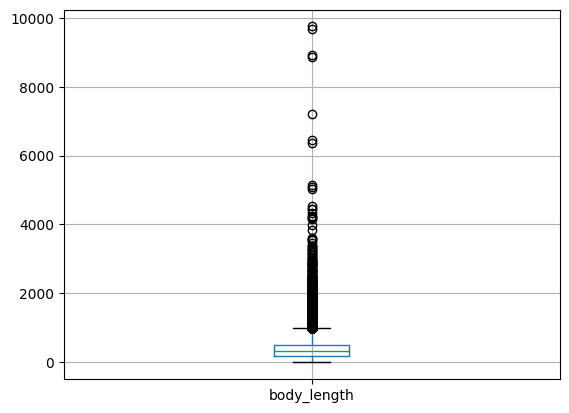

In [4]:
df[['body_length']].boxplot()

In [5]:
## we will filter about 5 % of our data 
low_b = df['body_length'].quantile(0.03)
up_b = df['body_length'].quantile(0.95)
print('lower bound is :{} ; higher bound is : {}'.format(low_b,up_b))
org_len = len(df)
df = df[(df['body_length']>low_b) & (df['body_length']<up_b)]
df = df[df['Keep_tag']==1]
docs = df['text'].tolist() ## get only the body 
print('orignial len: {} ; current len : {}; kept {:.1f}%'.format(org_len,len(docs),len(docs)/org_len*100))

lower bound is :21.0 ; higher bound is : 973.0
orignial len: 42320 ; current len : 8712; kept 20.6%


## Prepare data for topic modeling

In [6]:
## define an arg class to read arguments from json
args = Args('./args/train_args.json')
for attr, value in args.__dict__.items():
    print(f"{attr} = {value}")

verbose = False
model_name = sentence-transformers/all-MiniLM-L6-v2
model_checkpoint = sentence-transformers/all-MiniLM-L6-v2
n_neighbors = 15
n_components = 5
min_cluster_size = 5
min_samples = 5
min_df = 5
nr_topics = auto
metric = euclidean
calculate_probabilities = False
top_n_words = 10


In [7]:
#### load sentence embeding model and encode docs
if not LOAD_EMB:
    print('use model : {}'.format(args.model_name))
    sentence_model = SentenceTransformer(args.model_name)
    embeddings = sentence_model.encode(docs, show_progress_bar=True) ## encode sentences 
    assert len(docs)==len(embeddings)
    embeddings = np.array(embeddings)
    docs = np.array(docs)
    np.save(emb_path,embeddings)
    np.save(docs_path,docs)
else:
    print('Load embeding from {}'.format(emb_path))
    embeddings = np.load(emb_path)
    docs = np.load(docs_path)
    assert len(docs)==len(embeddings)
    print('Number of docs: {}'.format(len(docs)))

use model : sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

### set up parameter search space 

In [8]:
## permutate all conbinations 
train_args_inputs = {
            'n_neighbors':[5,10],
            'n_components':[3,5],
            'min_cluster_size':[20,30,40,60,100],
            'min_samples': [5,20],
            'metric':['euclidean'],
            'top_n_words':[10],
            }
train_args_space = hyper_param_permutation(train_args_inputs)
#print(train_args_space)

In [9]:
# # Run one iteration 
# param = train_args_space[1]
# args.__dict__.update(param)
# topics,probabilities,topic_model = train_topic_model(args,docs,embeddings)

### iterate through all params

In [10]:
### if we wnat to run hpyer tuning
if TUNE:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"  ## set it to false to avoid warning message 
    all_res = []
    for idx,param in enumerate(tqdm(train_args_space)):
        args.__dict__.update(param)
        args.verbose=False
        # for attr, value in args.__dict__.items():
        #     print(f"{attr} = {value}")
        try:
            topics,probabilities,topic_model = train_topic_model(args,docs,embeddings)
            #coherence_scores,outlier_percent,n_topics,diversity_score = train_and_eval(args,docs,embeddings)
            coherence_scores,outlier_percent,n_topics,diversity_score = eval_topic_model(docs,topics,probabilities,
                                                                                            topic_model,n_workers=16)
        except Exception as e:
            print('-- Error -- \n{}\n{}'.format(param,e))
            coherence_scores,outlier_percent,n_topics,diversity_score = (None,None,None,None)
        res_dict = pack_update_param(param,coherence_scores,outlier_percent,n_topics,diversity_score)
        all_res.append(res_dict)
        if args.verbose:
            print(res_dict)

    ## print out results 
    res_df = pd.DataFrame(all_res)
    res_df = res_df.sort_values(by='coherence', ascending=False)
    best_param = res_df.iloc[0].to_dict()
    print(best_param)
    res_df.head()
else:
    best_param={}

100%|██████████| 40/40 [3:41:49<00:00, 332.73s/it]  

{'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 40, 'min_samples': 5, 'metric': 'euclidean', 'top_n_words': 10, 'coherence': 0.40054110795944003, 'diversity': 0.9, 'outlier': 0.19352617079889808, 'number_topics': 7}


In [11]:
res_df.head()

,n_neighbors,n_components,min_cluster_size,min_samples,metric,top_n_words,coherence,diversity,outlier,number_topics
34,10,5,40,5,euclidean,10,0.400541,0.900000,0.193526,7
35,10,5,40,20,euclidean,10,0.384596,0.941667,0.251148,12
28,10,3,100,5,euclidean,10,0.381374,0.900000,0.238981,9
8,5,3,100,5,euclidean,10,0.366286,0.900000,0.188131,20
36,10,5,60,5,euclidean,10,0.355853,0.870588,0.202479,17


### retrain model with best param 

In [12]:
best_param={'n_neighbors': 10, 
            'n_components': 5, 
            'min_cluster_size': 20, 
            'min_samples': 20, 
            'metric': 'euclidean', 
            'top_n_words': 10}

In [13]:
args.__dict__.update(best_param)
args.verbose=False
args.TUNE=False
topics,probabilities,topic_model = train_topic_model(args,docs,embeddings)
topic_model.save(topic_model_out_path, save_embedding_model=True)
print('Model was saved at : {}'.format(topic_model_out_path))

Model was saved at : /data/chuang/news_scrape/data/news_search_res/topic_model



### Topic model visual evaluation 

In [14]:
topic_model.visualize_barchart(top_n_topics=20)

In [15]:
topic_model.visualize_topics()